In [7]:
# import packages
import numpy as np
import pandas as pd

# import machine learning models that we will use to decide whether or not to buy/sell stock
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# import visualization package
import matplotlib.pyplot as plt
plt.style.use('bmh')

### Retrieve data for stock market analysis from yahoo

In [8]:
# define configuration data 
offset = 0
limit = 3000
period = '1y' # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

# download all traded symbols from NASDAQ
data = pd.read_csv("http://www.nasdaqtrader.com/dynamic/SymDir/nasdaqtraded.txt", sep='|')
data_clean = data[data['Test Issue'] == 'N']
symbols = data_clean['NASDAQ Symbol'].tolist()
print('total number of symbols traded = {}'.format(len(symbols)))

total number of symbols traded = 10499


In [8]:
# ! pip install yfinance
! mkdir hist

In [9]:
import yfinance as yf
import os, contextlib

limit = limit if limit else len(symbols)
end = min(offset + limit, len(symbols))
is_valid = [False] * len(symbols)
# force silencing of verbose API
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        for i in range(offset, end):
            s = symbols[i]
            data = yf.download(s, period=period)
            if len(data.index) == 0:
                continue
        
            is_valid[i] = True
            data.to_csv('hist/{}.csv'.format(s))

print('Total number of valid symbols downloaded = {}'.format(sum(is_valid)))

Total number of valid symbols downloaded = 2683


In [12]:
# load csv files with data
valid_data = data_clean[is_valid]
valid_data.to_csv('symbols_valid_meta.csv', index=False)

# make folders for stocks and etfs
# !mkdir stocks
# !mkdir etfs

# separate etf and stock from the data
etfs = valid_data[valid_data['ETF'] == 'Y']['NASDAQ Symbol'].tolist()
stocks = valid_data[valid_data['ETF'] == 'N']['NASDAQ Symbol'].tolist()

import shutil
from os.path import isfile, join

def move_symbols(symbols, dest):
    for s in symbols:
        filename = '{}.csv'.format(s)
        shutil.move(join('hist', filename), join(dest, filename))
        
move_symbols(etfs, "etfs")
move_symbols(stocks, "stocks")

FileNotFoundError: [Errno 2] No such file or directory: 'hist\\AAA.csv'

### Look at data that we acquired

In [14]:
# testing reading with a single csv file that was collected
df = pd.read_csv('stocks/A.csv')

In [15]:
# reading first 6 rows of dataset
df.head(6)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-30,77.959999,78.440002,75.989998,76.660004,76.120834,1795200
1,2020-05-01,75.550003,76.099998,73.570000,74.209999,73.688049,1618600
2,2020-05-04,74.279999,74.620003,73.419998,74.559998,74.035599,1555400
3,2020-05-05,74.910004,77.580002,74.830002,76.370003,75.832863,1476100
4,2020-05-06,76.690002,78.830002,76.650002,77.870003,77.322311,2303600
5,2020-05-07,78.769997,79.330002,77.540001,78.500000,77.947876,1190600


In [16]:
df = df [['Close']]
df.head(6)

,Close
0,76.660004
1,74.209999
2,74.559998
3,76.370003
4,77.870003
5,78.500000


In [17]:
# create prediction x days in the future
future_days = 25

# create data shifted for x days in the future
df['Prediction'] = df[['Close']].shift(-future_days)
df.head(6)

,Close,Prediction
0,76.660004,90.379997
1,74.209999,90.290001
2,74.559998,89.769997
3,76.370003,89.809998
4,77.870003,85.029999
5,78.500000,86.110001


In [18]:
df.tail(6)

,Close,Prediction
246,134.529999,NaN
247,136.679993,NaN
248,137.339996,NaN
249,136.479996,NaN
250,134.800003,NaN
251,134.149994,NaN


In [19]:
# create feature dataset, convert to numpy array, then remove 'x' row and days
X = np.array(df.drop(['Prediction'],1))[:-future_days]
print(X)

[[ 76.66000366]
 [ 74.20999908]
 [ 74.55999756]
 [ 76.37000275]
 [ 77.87000275]
 [ 78.5       ]
 [ 79.70999908]
 [ 81.26999664]
 [ 79.84999847]
 [ 80.16000366]
 [ 81.63999939]
 [ 81.58999634]
 [ 83.66000366]
 [ 81.97000122]
 [ 81.70999908]
 [ 80.75      ]
 [ 84.98000336]
 [ 86.12999725]
 [ 86.18000031]
 [ 86.69000244]
 [ 88.13999939]
 [ 89.91000366]
 [ 90.29000092]
 [ 90.48999786]
 [ 91.13999939]
 [ 90.37999725]
 [ 90.29000092]
 [ 89.76999664]
 [ 89.80999756]
 [ 85.02999878]
 [ 86.11000061]
 [ 86.95999908]
 [ 87.44000244]
 [ 87.91999817]
 [ 88.20999908]
 [ 88.73000336]
 [ 88.52999878]
 [ 89.27999878]
 [ 86.55999756]
 [ 87.26000214]
 [ 85.90000153]
 [ 87.29000092]
 [ 88.37000275]
 [ 88.11000061]
 [ 88.68000031]
 [ 89.30999756]
 [ 89.20999908]
 [ 89.54000092]
 [ 89.91999817]
 [ 89.41999817]
 [ 89.26000214]
 [ 90.69000244]
 [ 92.87999725]
 [ 92.86000061]
 [ 94.37000275]
 [ 95.20999908]
 [ 96.01999664]
 [ 96.34999847]
 [ 96.66000366]
 [ 94.80999756]
 [ 97.26999664]
 [ 95.30000305]
 [ 97.09

In [20]:
# create target data set
y = np.array(df['Prediction'])[:-future_days]
print(y)

[ 90.37999725  90.29000092  89.76999664  89.80999756  85.02999878
  86.11000061  86.95999908  87.44000244  87.91999817  88.20999908
  88.73000336  88.52999878  89.27999878  86.55999756  87.26000214
  85.90000153  87.29000092  88.37000275  88.11000061  88.68000031
  89.30999756  89.20999908  89.54000092  89.91999817  89.41999817
  89.26000214  90.69000244  92.87999725  92.86000061  94.37000275
  95.20999908  96.01999664  96.34999847  96.66000366  94.80999756
  97.26999664  95.30000305  97.09999847  95.93000031  96.33000183
  99.08999634  97.52999878  97.88999939  97.44999695  97.77999878
  97.13999939  96.30000305  97.62999725  98.76999664  97.37000275
  97.51000214  97.86000061  97.95999908  97.77999878  98.30000305
  97.59999847  98.33999634  99.33000183  99.01999664  99.90000153
 100.41999817 101.12000275 103.41999817  99.63999939  96.83999634
  95.13999939  97.93000031  98.56999969  98.59999847  99.41999817
 100.37000275  99.91999817  99.59999847  99.37999725  98.12999725
  98.62000

In [21]:
# split data into 75% training 25% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [23]:
# create models

# create decision tree regressor model, train with training data
tree = DecisionTreeRegressor().fit(x_train, y_train)

# create linear regression model
lr = LinearRegression().fit(x_train, y_train)

In [24]:
# get last 'x' rows of feature data
x_future = df.drop(['Prediction'], 1)[:-future_days]
x_future = x_future.tail(future_days)
x_future = np.array(x_future)
x_future

array([[127.68000031],
       [126.87000275],
       [123.5       ],
       [122.41999817],
       [125.01999664],
       [122.09999847],
       [122.06999969],
       [124.48000336],
       [123.63999939],
       [119.30000305],
       [114.98999786],
       [116.13999939],
       [116.08000183],
       [119.83999634],
       [119.98999786],
       [121.83000183],
       [121.44000244],
       [124.04000092],
       [123.        ],
       [122.51999664],
       [122.58999634],
       [122.69000244],
       [123.61000061],
       [121.98000336],
       [120.83999634]])

In [26]:
# show model tree prediction
tree_prediction = tree.predict(x_future)
print(tree_prediction)
print()

# show linear regression
lr_prediction = lr.predict(x_future)
print(lr_prediction)
print()

[121.98000336 122.69000244 125.41999817 124.83999634 127.13999939
 127.69000244 130.         131.03999329 129.33999634 130.69000244
 131.91000366 131.27000427 132.97000122 131.97000122 131.97000122
 134.58000183 133.5        132.46000671 133.83000183 134.52999878
 136.67999268 137.33999634 129.33999634 134.80000305 134.1499939 ]

[131.62419932 130.87187439 127.74181918 126.73871455 129.15359055
 126.44149915 126.41363631 128.65204532 127.87185047 123.84086618
 119.83773763 120.90585791 120.85013223 124.3424114  124.48173267
 126.19072653 125.82849549 128.24337149 127.27741967 126.83159303
 126.89660868 126.98949425 127.84398763 126.3300478  125.27121041]



C:\Users\77jen\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


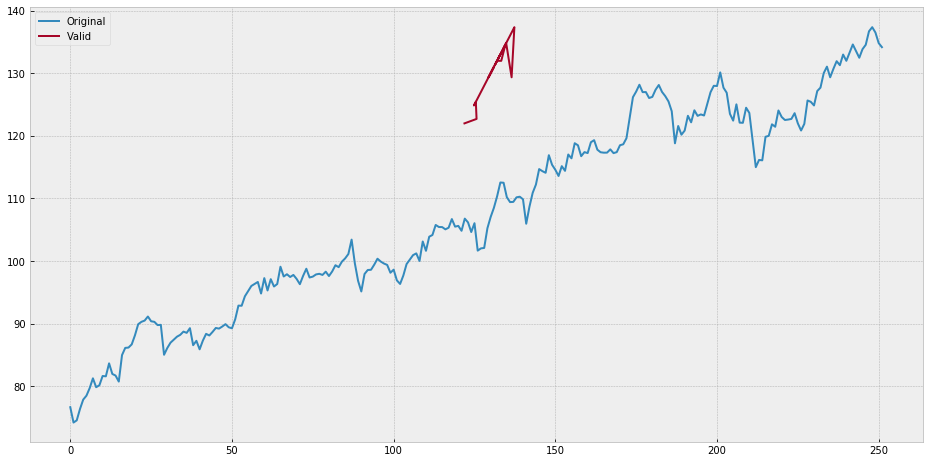

In [31]:
# visualize data
predictions = tree_prediction
valid = df[X.shape[0]:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title = 'Stock Market Prediction'
plt.xlabel = 'Days'
plt.ylabel = 'Close Price ($)'
plt.plot(df['Close'])
plt.plot(valid['Close'], valid['Predictions'])
plt.legend(['Original', 'Valid', 'Predicted'])
plt.show()

C:\Users\77jen\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


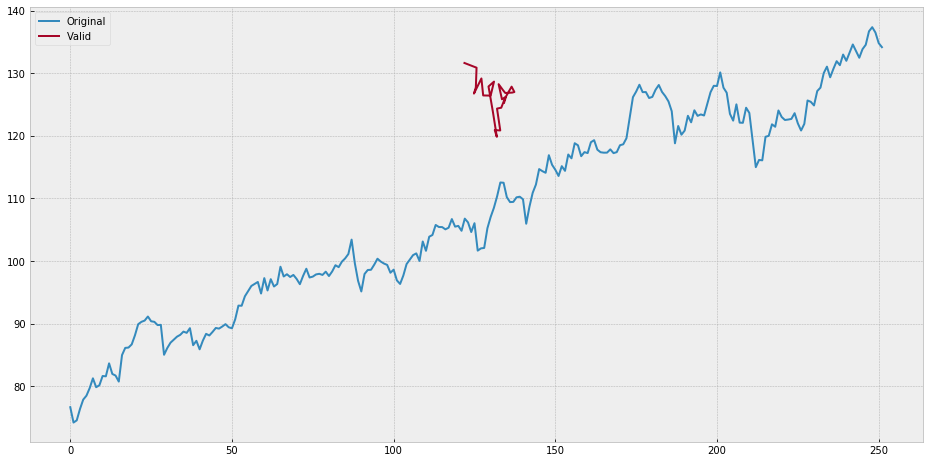

In [32]:
# visualize data for linear regression
predictions = lr_prediction
valid = df[X.shape[0]:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title = 'Stock Market Prediction'
plt.xlabel = 'Days'
plt.ylabel = 'Close Price ($)'
plt.plot(df['Close'])
plt.plot(valid['Close'], valid['Predictions'])
plt.legend(['Original', 'Valid', 'Predicted'])
plt.show()

## Week 2: Stock Market

### Issues encountered from first week:
-tried to obtain beginning of all time record for all stocks through the API, resulted in hours of data collection, cut down to 10 years was still too large, finally cut down to 1 year for dataset I will be using [spent a lot of time sourcing data then attempting to gather and collect it]<br/>
-...then there is the messed up analytics graph that was created as a result of my code :D

### Goals:
-fix messed up prediction graph <br/>
-get secondary data that we will match up by day for comparision and more meaningful analysis <br/>
-had trouble obtaining stock data due to the large data size <br/>
-focus on specific market <br/>